In [17]:
!pip install livelossplot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping 
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
import cv2

Tensorflow version: 2.4.1


In [18]:
train_dir ='../input/eyes-open-or-closed/dataset/train'
test_dir  ='../input/eyes-open-or-closed/dataset/test'

In [55]:
valSET = []
for feature in os.listdir("../input/eyes-open-or-closed/dataset"):
    f_list=os.listdir("../input/eyes-open-or-closed/dataset/" + feature)
    print(str(len(os.listdir("../input/eyes-open-or-closed/dataset/" + feature))) + " " + feature + " detected")
    for state in f_list:
        print("\t",str(len(os.listdir("../input/eyes-open-or-closed/dataset/" + feature+"/"+state))) + " " + state + " images")
        for img in os.listdir("../input/eyes-open-or-closed/dataset/" + feature+"/"+state):
            if feature=="test":
                a="../input/eyes-open-or-closed/dataset/" + feature+"/"+state+"/"+img
                x=cv2.resize(cv2.imread(a),(86,86))
                x = cv2.cvtColor(x,cv2.COLOR_BGR2GRAY)
                y=state
                valSET.append((x,y))
print(len(valSET))

2 test detected
	 360 Open_Eyes images
	 240 Closed_Eyes images
2 train detected
	 1640 Open_Eyes images
	 1760 Closed_Eyes images
600


In [4]:
width, height = 86, 86
img_size = 86
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                          rotation_range=7,
                                                          horizontal_flip=True,
                                                          validation_split=0.05
                                                         ).flow_from_directory(train_dir,
                                                                               class_mode = 'categorical',
                                                                               color_mode="grayscale",
                                                                               batch_size = 8,
                                                           target_size=(width,height),
                                                                              subset="training")
validation_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                         ).flow_from_directory(test_dir,
                                                                               class_mode = 'categorical',
                                                                               color_mode="grayscale",
                                                                               batch_size = 8,
                                                                               shuffle = False,
                                                           target_size=(width,height))
validing=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                          rotation_range=7,
                                                          horizontal_flip=True,
                                                         validation_split=0.05
                                                        ).flow_from_directory(train_dir,
                                                                              batch_size = 8,
                                                                              class_mode = 'categorical',
                                                                              color_mode="grayscale",
                                                           target_size=(width,height),subset='validation',shuffle=True)

Found 3230 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


In [5]:
from keras.models import Sequential ,Model
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization  ,Activation ,GlobalMaxPooling2D
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau

In [6]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99,decay=0.001/32)
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]

In [7]:
num_classes = 2
num_detectors=32

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (img_size, img_size, 1)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))

In [8]:
network.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [9]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 86, 86, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 86, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 86, 86, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 64)        1

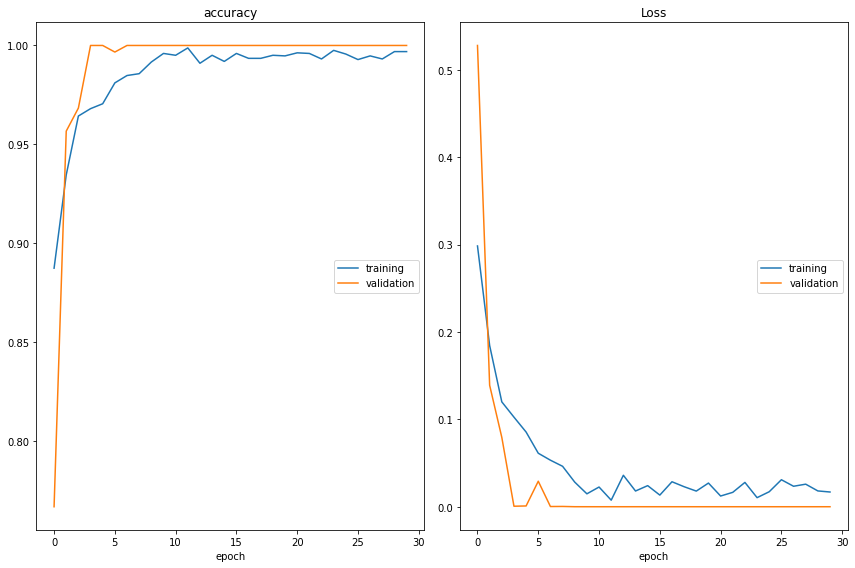

accuracy
	training         	 (min:    0.887, max:    0.999, cur:    0.997)
	validation       	 (min:    0.767, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.008, max:    0.298, cur:    0.017)
	validation       	 (min:    0.000, max:    0.528, cur:    0.000)

Epoch 00030: saving model to Eyes.h5


In [10]:
epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("Eyes.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=2)
callbacks = [EarlyStop ,PlotLossesKerasTF(), checkpoint, reduce_lr]

history = network.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [11]:
model_json = network.to_json()
with open("eyes.json", "w") as json_file:
    json_file.write(model_json)

In [12]:
from sklearn.metrics import classification_report as csr

In [14]:
y_pd = network.predict(validation_generator)

In [22]:
print("len of valiadation set:",len(valSET))

len of valiadation set: 600


In [32]:
print(valSET[400][1])
print(valSET[0][1])

Closed_Eyes
Open_Eyes


In [ ]:
network.save('eyes.h5')

In [56]:
val = np.array(valSET)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [57]:
val.shape

(600, 2)

In [68]:
x_val=[]
y_val=[]
for x,y in val:
    if "open" in y.lower():
        y_val.append(1)
    else:
        y_val.append(0)
    x = np.expand_dims(x,axis=2)
    x_val.append(x)
#     print(x.shape)
#     break
    
    

In [69]:
x_val=np.array(x_val)
y_val=np.array(y_val)

In [70]:
x_val.shape

(600, 86, 86, 1)

In [71]:
y_val.shape

(600,)

In [72]:
import pandas as pd
pd.Series(y_val).value_counts()

1    360
0    240
dtype: int64

In [73]:
y_pd=network.predict(x_val)

In [76]:
y_pd=np.argmax(y_pd,axis=1)

In [77]:
y_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [79]:
print(csr(y_val,y_pd))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       240
           1       1.00      0.97      0.98       360

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

